In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nglview as nv

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, pca, diffusionmap, distances
from MDAnalysis.analysis.hydrogenbonds import hbond_analysis

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [4]:
log_df = pd.read_csv("result/log.txt",sep="\t")

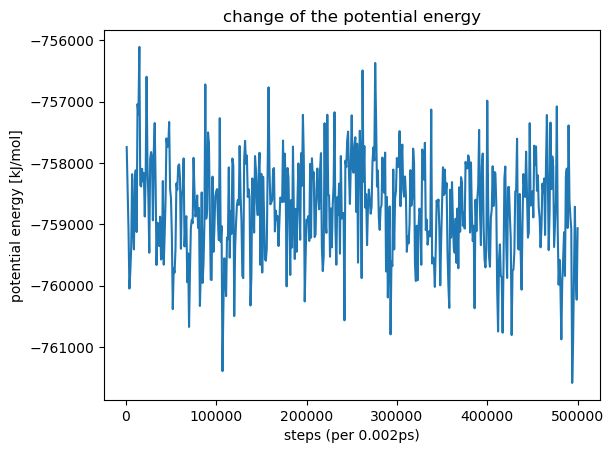

In [5]:
x = log_df["Step"]
y = log_df["Potential Energy (kJ/mole)"]
plt.plot(x,y)
plt.title("change of the potential energy")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("potential energy [kJ/mol]")
plt.show()

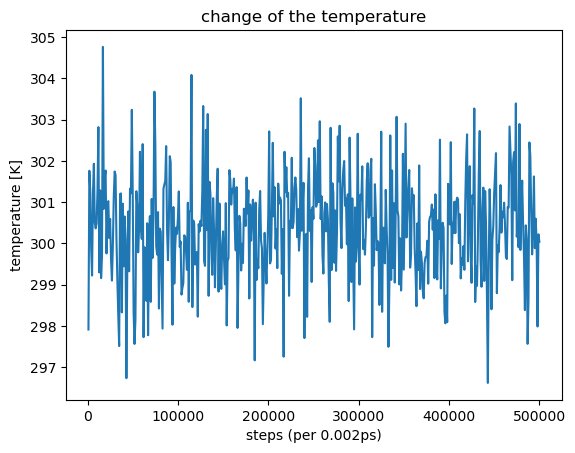

In [6]:
x = log_df["Step"]
y2 = log_df["Temperature (K)"]
plt.plot(x, y2)
plt.title("change of the temperature")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("temperature [K]")
plt.show()

In [3]:
md_universe = mda.Universe("data/3poz_SMIRNOFF_processed.pdb","result/trajectory.dcd")
alignment = align.AlignTraj(mobile=md_universe,reference=md_universe,select="name CA",in_memory=True)
alignment.run()

In [11]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=49)

In [12]:
md_universe.trajectory[0]
RMSD_analysis = rms.RMSD(md_universe,reference=md_universe,select="backbone",
                         groupselections=["protein","resname UNK"],ref_frame=0)
RMSD_analysis.run()

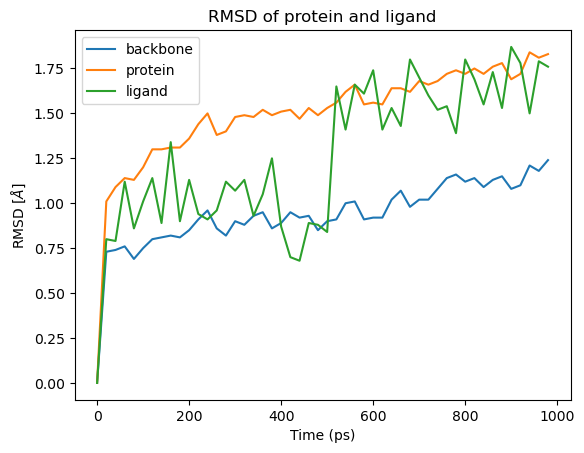

In [13]:
# backbone基準としたRMSDで描画
column_names = ['frame', 'time(ps)', 'backbone', 'protein', 'ligand']
rmsd_df = pd.DataFrame(np.round(RMSD_analysis.results.rmsd, 2), columns = column_names)

plt.plot(rmsd_df['time(ps)'], rmsd_df['backbone'], label="backbone")
plt.plot(rmsd_df['time(ps)'], rmsd_df['protein'], label="protein")
plt.plot(rmsd_df['time(ps)'], rmsd_df['ligand'], label="ligand")
plt.legend(loc="upper left")
plt.xlabel("Time (ps)")
plt.ylabel("RMSD [$\AA$]")
plt.title("RMSD of protein and ligand")

plt.show()

### フレーム間のRMSD

In [14]:
pairwase_protein = diffusionmap.DistanceMatrix(md_universe, select = "protein")
pairwase_protein.run()
dist_matrix_protein = pairwase_protein.results.dist_matrix

pairwase_ligand = diffusionmap.DistanceMatrix(md_universe, select = "resname UNK")
pairwase_ligand.run()
dist_matrix_ligand = pairwase_ligand.results.dist_matrix

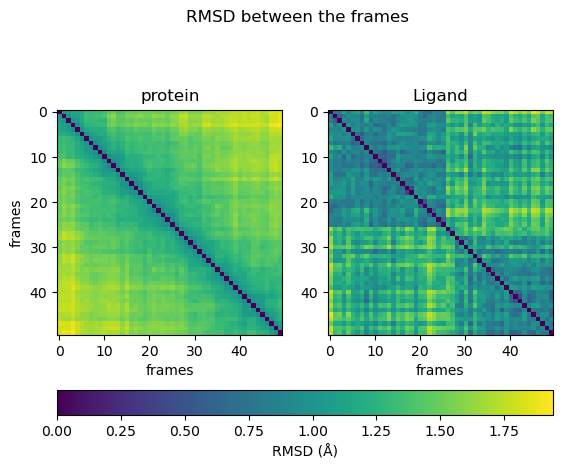

In [15]:
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)")

### ProLIF

In [16]:
import prolif as plf
from prolif.plotting.network import LigNetwork

In [17]:
lig = md_universe.atoms.select_atoms("resname UNK")
prot = md_universe.atoms.select_atoms("protein")
fp = plf.Fingerprint()
fp.run(md_universe.trajectory[::10],lig,prot)

  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x72055a07f150>

In [18]:
df_fp = fp.to_dataframe()
df_fp

ligand          UNK1.C           
protein        ALA43.A    THR90.A
interaction VdWContact VdWContact
Frame                            
0                False      False
10                True       True
20               False      False
30               False      False
40               False      False

In [23]:
df_lpt = fp.to_dataframe()
lmol = plf.Molecule.from_mda(lig)
net = LigNetwork.from_fingerprint(fp,lmol,kind="frame",frame=10,display_all=True)
net.display()

---

### 原子間距離

In [46]:
a_THR90 = md_universe.select_atoms("resid 90 and name N")
a_UNK_Cl = md_universe.select_atoms("resname UNK and name N1")

In [47]:
dist = distances.dist(a_THR90,a_UNK_Cl)
print(dist)

[[90.       ]
 [ 1.       ]
 [ 6.7415094]]


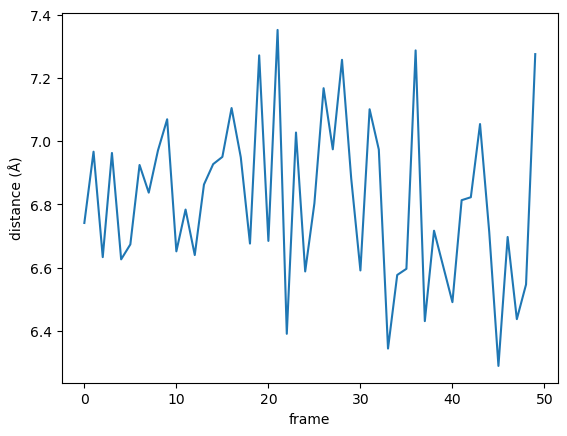

In [48]:
distlist = []
for _ in md_universe.trajectory:
    dist_t = distances.dist(a_THR90,a_UNK_Cl)[2][0]
    distlist.append(dist_t)
plt.plot(distlist)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.show()

### RMSF

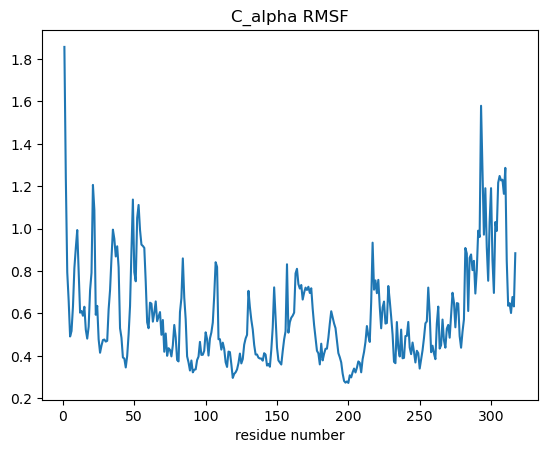

In [49]:
C_alphas = md_universe.select_atoms("name CA")
RMSF_analysis = rms.RMSF(C_alphas)
RMSF_analysis.run()

residue_numbers = C_alphas.resnums
plt.plot(residue_numbers, RMSF_analysis.results.rmsf)
plt.title("C_alpha RMSF")
plt.xlabel("residue number")
plt.show()

### 相互相関解析